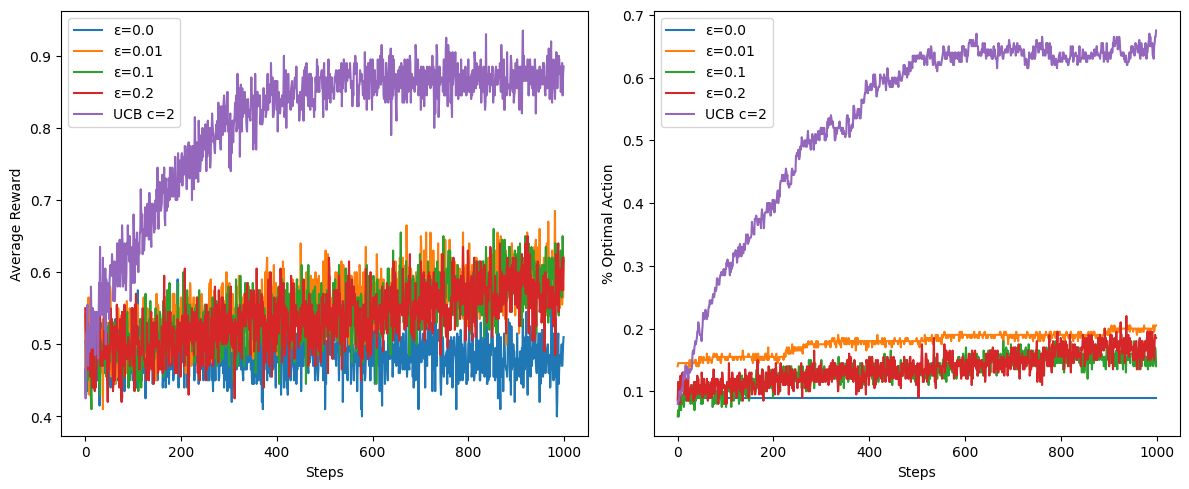

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class BanditEnv:
    """Окружение для задачи n-рукого бандита"""
    def __init__(self, n_arms, reward_probs=None):
        self.n_arms = n_arms
        if reward_probs is None:
            # Случайные вероятности успеха для каждой руки
            self.reward_probs = torch.rand(n_arms)
        else:
            self.reward_probs = torch.tensor(reward_probs)

    def step(self, action):
        # Возвращает награду 1 с вероятностью reward_probs[action], иначе 0
        if torch.rand(1) < self.reward_probs[action]:
            return 1.0
        return 0.0

class EpsilonGreedyAgent:
    """Агент с ε-жадной стратегией"""
    def __init__(self, n_arms, epsilon=0.1):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.q_values = torch.zeros(n_arms)  # Оценки значений действий
        self.action_counts = torch.zeros(n_arms)  # Количество выборов каждого действия

    def select_action(self):
        if torch.rand(1) < self.epsilon:
            # Исследование: случайное действие
            return torch.randint(0, self.n_arms, (1,)).item()
        else:
            # Эксплуатация: лучшее известное действие
            return torch.argmax(self.q_values).item()

    def update(self, action, reward):
        # Обновляем оценку значения действия
        self.action_counts[action] += 1
        alpha = 1 / self.action_counts[action]  # Шаг обучения
        self.q_values[action] += alpha * (reward - self.q_values[action])

class UCBAgent:
    """Агент с стратегией Upper Confidence Bound (UCB)"""
    def __init__(self, n_arms, c=2):
        self.n_arms = n_arms
        self.c = c  # Параметр исследования
        self.q_values = torch.zeros(n_arms)
        self.action_counts = torch.zeros(n_arms)
        self.total_counts = 0

    def select_action(self):
        if self.total_counts < self.n_arms:
            # Пробуем каждое действие хотя бы раз
            return self.total_counts
        else:
            # Вычисляем UCB для каждого действия
            ucb_values = self.q_values + self.c * torch.sqrt(
                torch.log(torch.tensor(self.total_counts)) / self.action_counts)
            return torch.argmax(ucb_values).item()

    def update(self, action, reward):
        self.total_counts += 1
        self.action_counts[action] += 1
        alpha = 1 / self.action_counts[action]
        self.q_values[action] += alpha * (reward - self.q_values[action])

def train_bandit(env, agent, n_steps=1000):
    rewards = []
    optimal_actions = []
    optimal_action = torch.argmax(env.reward_probs).item()

    for step in range(n_steps):
        action = agent.select_action()
        reward = env.step(action)
        agent.update(action, reward)

        rewards.append(reward)
        optimal_actions.append(1 if action == optimal_action else 0)

    return torch.tensor(rewards), torch.tensor(optimal_actions)

def run_experiment(n_arms=10, n_runs=200, n_steps=1000):
    # Сравнение разных стратегий
    epsilons = [0.0, 0.01, 0.1, 0.2]
    agents = {
        f'ε={epsilon}': EpsilonGreedyAgent(n_arms, epsilon)
        for epsilon in epsilons
    }
    agents['UCB c=2'] = UCBAgent(n_arms, c=2)

    results = {name: {'rewards': [], 'optimal': []} for name in agents}

    for run in range(n_runs):
        env = BanditEnv(n_arms)
        for name, agent in agents.items():
            rewards, optimal = train_bandit(env, agent(n_arms) if callable(agent) else agent, n_steps)
            results[name]['rewards'].append(rewards)
            results[name]['optimal'].append(optimal)

    # Усредняем результаты по всем запускам
    avg_results = {}
    for name in results:
        avg_rewards = torch.stack(results[name]['rewards']).float().mean(0)
        avg_optimal = torch.stack(results[name]['optimal']).float().mean(0)
        avg_results[name] = (avg_rewards, avg_optimal)

    # Визуализация
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for name, (rewards, _) in avg_results.items():
        plt.plot(rewards.numpy(), label=name)
    plt.xlabel('Steps')
    plt.ylabel('Average Reward')
    plt.legend()

    plt.subplot(1, 2, 2)
    for name, (_, optimal) in avg_results.items():
        plt.plot(optimal.numpy(), label=name)
    plt.xlabel('Steps')
    plt.ylabel('% Optimal Action')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Запуск эксперимента
run_experiment()